# FIFA 2019 Players' Data Analysis

## The goal of this report is to find out undervalued and overvalued soccer players.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor

from pandas.core import datetools
%matplotlib inline

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.


### Data Cleaning

In [2]:
# use data from 2018 to train my model and will test the model with data from 2019 later in the report.
df2018 = pd.read_csv('2018playerdata.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df2018.head(5)

,Unnamed: 0,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df2018.columns

Index(['Unnamed: 0', 'Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control',
       'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'GK diving', 'GK handling', 'GK kicking',
       'GK positioning', 'GK reflexes', 'Heading accuracy', 'Interceptions',
       'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties',
       'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys', 'CAM', 'CB', 'CDM', 'CF', 'CM', 'ID',
       'LAM', 'LB', 'LCB', 'LCM', 'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB',
       'Preferred Positions', 'RAM', 'RB', 'RCB', 'RCM', 'RDM', 'RF', 'RM',
       'RS', 'RW', 'RWB', 'ST'],
      dtype='object')

In [5]:
# delete euro sign and 'M' and 'K' from value ('M' was substituted to *1000000 and 'K' to *1000). 
def clean_value(dataframe):
    dataframe['Value'] = dataframe['Value'].str.replace('€', '')
    vals = dataframe['Value'].values
    new_vals = list()
    for val in vals:
        if 'M' in val:
            val = val.replace('M', '')
            val = float(val)
            val = val*1000000
        elif 'K' in val:
            val = val.replace('K', '')
            val = float(val)
            val = val*1000
        new_vals.append(val)
    new_vals = np.array(new_vals)
    dataframe['Value'] = new_vals
    return dataframe['Value']

df2018['Value'] = clean_value(df2018)

In [6]:
# if delete rows (players) if any of inputs is 0, since it's impossible
df2018 = df2018[~(df2018 == 0).any(axis=1)]

In [7]:
# eliminate dashes and pluses in those columns
def eliminate_dash(dataframe, column):
    vals = dataframe[column].values
    new_vals = list()
    for val in vals:
        if '-' in str(val):
            dash_loc = str(val).index('-')
            val = float(str(val)[:dash_loc])-float(str(val)[dash_loc+1:])
        elif '+' in str(val):
            plus_loc = str(val).index('+')
            val = float(str(val)[:plus_loc])+float(str(val)[plus_loc+1:])
        new_vals.append(val)
    new_vals = np.array(new_vals)
    dataframe[column] = new_vals
    return dataframe[column]

In [9]:
# clean columns that have dashes and pluses, so that they have floats as their inputs
relevant_columns = ['Value', 'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control'
                   , 'Composure', 'Dribbling', 'GK diving', 'GK handling', 'GK kicking', 'GK positioning'
                   , 'GK reflexes', 'Jumping', 'Long passing', 'Reactions', 'Short passing', 'Strength'
                   , 'Crossing', 'Curve', 'Dribbling', 'Finishing', 'Free kick accuracy', 'Heading accuracy'
                   , 'Interceptions', 'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties'
                   , 'Positioning', 'Reactions', 'Short passing', 'Shot power', 'Sliding tackle'
                   , 'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision', 'Volleys']

for col in relevant_columns:
    df2018[col] = eliminate_dash(df2018, col)
#eliminate_dash(df2018, 'Free kick accuracy')

#### First, we need to divide data into goalkeepers vs field players

In [10]:
# first, find goalkeepers
df2018['Preferred Positions'] = df2018['Preferred Positions'].str.replace(" ","")
df2018_gk = df2018[df2018['Preferred Positions'] == 'GK']
df2018_field = df2018[df2018['Preferred Positions'] != 'GK']

# choose relevant columns for goalkeepers
columns_gk = ['Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value'
              ,'Acceleration', 'Agility', 'Balance', 'Ball control', 'Composure', 'Dribbling'
             , 'GK diving', 'GK handling', 'GK kicking', 'GK positioning', 'GK reflexes', 'Jumping', 'Long passing'
             , 'Reactions', 'Short passing', 'Strength']

columns_field = ['Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value'
              ,'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control', 'Composure'
              , 'Crossing', 'Curve', 'Dribbling', 'Finishing', 'Free kick accuracy', 'Heading accuracy'
              , 'Interceptions', 'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties'
              , 'Positioning', 'Reactions', 'Short passing', 'Shot power', 'Sliding tackle'
              , 'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision', 'Volleys']
df2018_gk = df2018_gk[columns_gk]
df2018_field = df2018_field[columns_field]

In [11]:
# change data types to float for relevant columns

relevant_columns_gk = ['Age', 'Overall', 'Potential', 'Value'
             ,'Acceleration', 'Agility', 'Balance', 'Ball control', 'Composure', 'Dribbling'
             , 'GK diving', 'GK handling', 'GK kicking', 'GK positioning', 'GK reflexes', 'Jumping', 'Long passing'
             , 'Reactions', 'Short passing', 'Strength']

relevant_columns_field = ['Age', 'Overall', 'Potential', 'Value'
              ,'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control', 'Composure'
              , 'Crossing', 'Curve', 'Dribbling', 'Finishing', 'Free kick accuracy', 'Heading accuracy'
              , 'Interceptions', 'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties'
              , 'Positioning', 'Reactions', 'Short passing', 'Shot power', 'Sliding tackle'
              , 'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision', 'Volleys']

for col in relevant_columns_gk:
    df2018_gk[col] = df2018_gk[col].astype('float')
for col in relevant_columns_field:
    df2018_field[col] = df2018_field[col].astype('float')

In [12]:
df2018_gk.describe()

,Age,Overall,Potential,Value,Acceleration,Agility,Balance,Ball control,Composure,Dribbling,GK diving,GK handling,GK kicking,GK positioning,GK reflexes,Jumping,Long passing,Reactions,Short passing,Strength
count,2029.000000,2029.000000,2029.000000,2.029000e+03,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.00000
mean,26.077378,64.710202,69.724988,1.572977e+06,38.898472,40.688024,43.291769,20.052242,36.537703,14.049778,65.372597,62.919665,61.573189,63.087728,66.270577,58.207491,25.554460,59.286348,26.922129,61.05865
std,5.395541,7.710798,6.444213,4.295168e+06,10.943487,11.549215,10.846956,5.829111,12.769624,4.261079,7.907076,7.916786,7.895908,8.806555,8.397733,11.489161,7.959935,10.359767,7.399881,11.25533
min,16.000000,46.000000,46.000000,0.000000e+00,11.000000,14.000000,11.000000,8.000000,5.000000,2.000000,39.000000,43.000000,35.000000,38.000000,37.000000,13.000000,7.000000,28.000000,10.000000,12.00000
25%,22.000000,59.000000,65.000000,1.400000e+05,31.000000,33.000000,36.000000,16.000000,27.000000,11.000000,60.000000,58.000000,56.000000,57.000000,60.000000,52.000000,20.000000,52.000000,22.000000,54.00000
50%,26.000000,65.000000,70.000000,3.750000e+05,40.000000,38.000000,43.000000,20.000000,33.000000,14.000000,65.000000,63.000000,61.000000,63.000000,66.000000,59.000000,24.000000,60.000000,26.000000,62.00000
75%,30.000000,70.000000,74.000000,9.750000e+05,47.000000,48.000000,51.000000,23.000000,45.000000,16.000000,71.000000,68.000000,66.000000,69.000000,72.000000,66.000000,30.000000,67.000000,31.000000,69.00000
max,47.000000,92.000000,94.000000,6.450000e+07,65.000000,74.000000,70.000000,54.000000,71.000000,33.000000,91.000000,91.000000,95.000000,91.000000,90.000000,85.000000,73.000000,88.000000,66.000000,85.00000


In [13]:
df2018_field.describe()

,Age,Overall,Potential,Value,Acceleration,Aggression,Agility,Balance,Ball control,Composure,...,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys
count,15951.000000,15951.000000,15951.000000,1.595100e+04,15951.000000,15951.000000,15951.000000,15951.000000,15951.000000,15951.000000,...,15951.000000,15951.000000,15951.000000,15951.000000,15951.000000,15951.000000,15951.000000,15951.000000,15951.000000,15951.000000
mean,25.025453,66.441853,71.375839,2.482893e+06,67.875995,59.538085,66.226067,66.429440,62.959752,60.618519,...,62.241866,62.309197,59.881826,49.584477,68.089524,67.413893,51.683343,65.835622,55.181117,47.071155
std,4.491327,6.862957,6.029571,5.415767e+06,11.866258,14.664987,12.494931,12.193334,10.296976,10.115365,...,8.960061,10.143995,13.338408,19.425178,11.552687,11.266104,19.442486,12.684755,13.089673,14.873347
min,16.000000,46.000000,46.000000,0.000000e+00,20.000000,13.000000,23.000000,21.000000,16.000000,25.000000,...,30.000000,21.000000,12.000000,10.000000,21.000000,27.000000,10.000000,21.000000,11.000000,11.000000
25%,21.000000,62.000000,67.000000,3.500000e+05,62.000000,49.000000,59.000000,59.000000,57.000000,54.000000,...,56.000000,57.000000,52.000000,32.000000,62.000000,61.000000,34.000000,58.000000,47.000000,35.000000
50%,25.000000,66.000000,71.000000,7.250000e+05,69.000000,61.000000,67.000000,67.000000,64.000000,61.000000,...,63.000000,63.000000,62.000000,56.000000,69.000000,68.000000,58.000000,67.000000,56.000000,47.000000
75%,28.000000,71.000000,75.000000,2.200000e+06,76.000000,70.000000,75.000000,75.000000,70.000000,68.000000,...,68.000000,69.000000,70.000000,65.000000,76.000000,75.000000,67.000000,75.000000,65.000000,59.000000
max,41.000000,93.000000,94.000000,1.230000e+08,96.000000,106.000000,96.000000,96.000000,95.000000,100.000000,...,95.000000,92.000000,98.000000,95.000000,110.000000,116.000000,99.000000,98.000000,94.000000,91.000000


In [14]:
# divide data into training set (60%) and validation set (40%)
gk_train, gk_val = train_test_split(df2018_gk, test_size = .4, random_state = 90)
field_train, field_val = train_test_split(df2018_field, test_size = .4, random_state = 90)

# training and validation set for goalkeepers
y_train_gk = gk_train['Value']
x_train_gk = gk_train.drop(columns=['Value', 'Name', 'Nationality', 'Club'])
y_val_gk = gk_val['Value']
x_val_gk = gk_val.drop(columns=['Value', 'Name', 'Nationality', 'Club'])

#training and validation set for field players
y_train_field = field_train['Value']
x_train_field = field_train.drop(columns=['Value', 'Name', 'Nationality', 'Club'])
y_val_field = field_val['Value']
x_val_field = field_val.drop(columns=['Value', 'Name', 'Nationality', 'Club'])

In [15]:
len(df2018_gk), len(df2018_field)

(2029, 15951)

In [16]:
len(x_train_gk.columns), len(x_train_field.columns)

(19, 32)

### Train the model - train and validate with 2018 players data and apply to 2019 players data

Response variable = Value

Predictor variables = Age, Overall, Potential, Acceleration, Agility, etc 

There are 2029 data and 19 predictors for goalkeepers. 15951 data and 32 predictors for field players.

OLS regression, Lasso regression, Random Forest, and KNN were used to compare different performances.

#### 1. OLS (Ordinary Least Squares) Linear Regression

In [17]:
# fit OLS
fitted_model_gk = LinearRegression().fit(x_train_gk, y_train_gk)
fitted_model_field = LinearRegression().fit(x_train_field, y_train_field)

In [18]:
# print out train and validation scores
train_score_gk = fitted_model_gk.score(x_train_gk, y_train_gk)
val_score_gk = fitted_model_gk.score(x_val_gk, y_val_gk)
train_score_field = fitted_model_field.score(x_train_field, y_train_field)
val_score_field = fitted_model_field.score(x_val_field, y_val_field)

scores = {"training score": [train_score_gk, train_score_field], "validation score": [val_score_gk, val_score_field]}
pd.DataFrame(scores, index=['goalkeepers', 'field players'])

,training score,validation score
goalkeepers,0.466366,0.398615
field players,0.478266,0.489031


Scores are pretty low, but let's first see histograms of residuals to verify if assumptions of linear regression hold. 

In [19]:
# A plot and a histogram of residuals
def residuals(x_train, y_train, model, name):
    pred_y = model.predict(x_train)
    residuals = y_train.values - pred_y
    fig, axs = plt.subplots(1, 2, figsize = (15, 5))
    fig.suptitle(f'Residual Analysis for {name}', size=17)
    axs[0].set_title('Plot of Residuals')
    axs[0].scatter(pred_y, residuals)
    axs[0].axhline(0, c='black')
    axs[0].set_xlabel(r'$\hat{y}$')

    axs[1].set_title('Histogram of Residuals')
    axs[1].hist(residuals)
    axs[1].axhline(0, c='black')
    axs[1].set_xlabel(r'residuals')

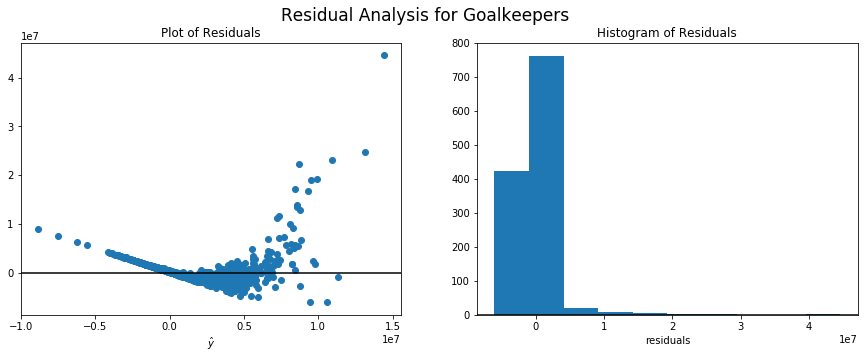

In [20]:
residuals(x_train_gk, y_train_gk, fitted_model_gk, 'Goalkeepers')

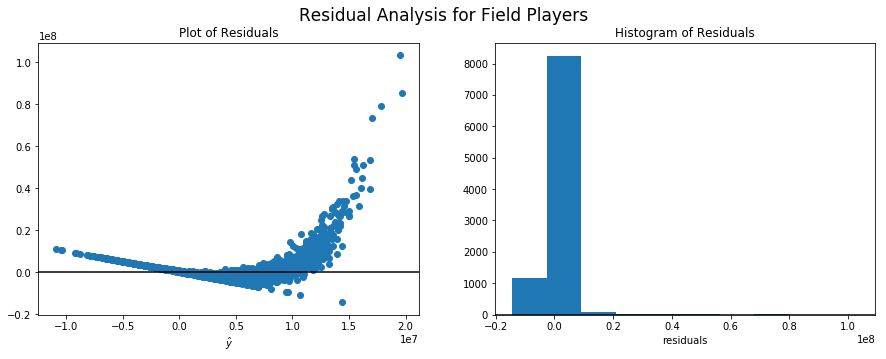

In [21]:
residuals(x_train_field, y_train_field, fitted_model_field, 'Field Players')

From the plot on the left, variance of residuals increases as $\hat{y}$ increases. There is also a pattern in residuals, indicating that there will be more than a linear relationship between predictors and the response variable. In addition, the histogram on the right shows that residuals are not normal, undermining the assumption of linear regression.

#### 2. Lasso Regression

In [22]:
# set lambdas, which determine the magnitude of shrinkage
alphas = (.1,.5,1,5,10,50,100)
fitted_lasso_gk = LassoCV(alphas=alphas, max_iter=100000, cv=5).fit(x_train_gk, y_train_gk)
fitted_lasso_field = LassoCV(alphas=alphas, max_iter=100000, cv=5).fit(x_train_field, y_train_field)

In [23]:
# print out train and validation scores
train_score_gk = fitted_lasso_gk.score(x_train_gk, y_train_gk)
val_score_gk = fitted_lasso_gk.score(x_val_gk, y_val_gk)
train_score_field = fitted_lasso_field.score(x_train_field, y_train_field)
val_score_field = fitted_lasso_field.score(x_val_field, y_val_field)

scores = {"training score": [train_score_gk, train_score_field], "validation score": [val_score_gk, val_score_field]}
pd.DataFrame(scores, index=['goalkeepers', 'field players'])

,training score,validation score
goalkeepers,0.466366,0.398601
field players,0.478266,0.489030


Training and validation scores are not significantly different for Lasso compared to scores for OLS regression, indicating that linear regression might not be a good method for this data. In addition, there is not much a difference in regression coefficients between OLS and Lasso (usually there are some significant differences as Lasso penalizes correlated features). 

#### 3. Random Forest

In [24]:
# fit random forest for both goalkeepers and field players
rf_gk = RandomForestRegressor(n_estimators = 200, max_depth = 50, random_state=42)
rf_field = RandomForestRegressor(n_estimators = 200, max_depth = 50, random_state=42)
rf_gk.fit(x_train_gk, y_train_gk)
rf_field.fit(x_train_field, y_train_field)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [25]:
print(f'Training score for goalkeepers is {rf_gk.score(x_train_gk, y_train_gk)}')
print(f'Validation score for goalkeepers is {rf_gk.score(x_val_gk, y_val_gk)}')

Training score for goalkeepers is 0.9776685695183612
Validation score for goalkeepers is 0.9073672976528225


In [26]:
print(f'Training score for field players is {rf_field.score(x_train_field, y_train_field)}')
print(f'Validation score for field players is {rf_field.score(x_val_field, y_val_field)}')

Training score for field players is 0.9955007859733418
Validation score for field players is 0.9746981500735119


Random forest demonstrates very strong performances for both goalkeepers and field players.

#### 4. KNN

In [27]:
# fit knn for both goalkeepers and field players
knn_gk = KNeighborsRegressor(n_neighbors=5)
knn_field = KNeighborsRegressor(n_neighbors=5)
knn_gk.fit(x_train_gk, y_train_gk)
knn_field.fit(x_train_field, y_train_field)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [28]:
# print out train and validation scores
train_score_gk = knn_gk.score(x_train_gk, y_train_gk)
val_score_gk = knn_gk.score(x_val_gk, y_val_gk)
train_score_field = knn_field.score(x_train_field, y_train_field)
val_score_field = knn_field.score(x_val_field, y_val_field)

scores = {"training score": [train_score_gk, train_score_field], "validation score": [val_score_gk, val_score_field]}
pd.DataFrame(scores, index=['goalkeepers', 'field players'])

,training score,validation score
goalkeepers,0.819701,0.674811
field players,0.857702,0.776435


KNN with n_neighbors =5 demonstrates pretty good performances for both goalkeepers and field players.

#### Random forest was selected as a final model as it demonstrated a much better performance than other methods.

### Find out undervalued and overvalued players from 2019 data using random forest

In [95]:
# read 2019 players data
df2019 = pd.read_csv('2019playerdata.csv')

# clean value column
df2019['Value'] = clean_value(df2019)
df2019['Value'] = df2019['Value'].astype('float')

In [96]:
# if delete rows (players) if any of inputs is 0, since it's impossible
df2019 = df2019[~(df2019 == 0).any(axis=1)]

In [97]:
# separate goalkeepers from field players
df2019_gk = df2019[df2019['Position']=='GK']
df2019_field = df2019[df2019['Position']!='GK']

# choose relevant columns for goalkeepers
columns_gk = ['Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value', 'Position'
              ,'Acceleration', 'Agility', 'Balance', 'BallControl', 'Composure', 'Dribbling'
             , 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Jumping', 'LongPassing'
             , 'Reactions', 'ShortPassing', 'Strength']

columns_field = ['Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value', 'Position'
              ,'Acceleration', 'Aggression', 'Agility', 'Balance', 'BallControl', 'Composure'
              , 'Crossing', 'Curve', 'Dribbling', 'Finishing', 'FKAccuracy', 'HeadingAccuracy'
              , 'Interceptions', 'Jumping', 'LongPassing', 'LongShots', 'Marking', 'Penalties'
              , 'Positioning', 'Reactions', 'ShortPassing', 'ShotPower', 'SlidingTackle'
              , 'SprintSpeed', 'Stamina', 'StandingTackle', 'Strength', 'Vision', 'Volleys']
df2019_gk = df2019_gk[columns_gk]
df2019_field = df2019_field[columns_field]

In [98]:
# change data types to float for relevant columns
relevant_columns_gk = ['Overall', 'Potential', 'Value', 'Acceleration', 'Agility', 'Balance', 'BallControl'
                   , 'Composure', 'Dribbling', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning'
                   , 'GKReflexes', 'Jumping', 'LongPassing', 'Reactions', 'ShortPassing', 'Strength']
relevant_columns_field = ['Overall', 'Potential', 'Value'
              ,'Acceleration', 'Aggression', 'Agility', 'Balance', 'BallControl', 'Composure'
              , 'Crossing', 'Curve', 'Dribbling', 'Finishing', 'FKAccuracy', 'HeadingAccuracy'
              , 'Interceptions', 'Jumping', 'LongPassing', 'LongShots', 'Marking', 'Penalties'
              , 'Positioning', 'Reactions', 'ShortPassing', 'ShotPower', 'SlidingTackle'
              , 'SprintSpeed', 'Stamina', 'StandingTackle', 'Strength', 'Vision', 'Volleys']

for col in relevant_columns_gk:
    df2019_gk[col] = df2019_gk[col].astype('float')
    
for col in relevant_columns_field:
    df2019_field[col] = df2019_field[col].astype('float')
    # impute mean value of each column for NAN values
    df2019_field[col] = df2019_field[col].fillna(df2019_field[col].mean())

In [105]:
# separate the response variable ('Value') from predictor variables
# For goalkeepers
y_variable_gk = df2019_gk['Value']
y_values_gk = y_variable_gk.values.astype('float')
x_variables_gk = df2019_gk.drop(columns=['Value', 'Name', 'Nationality', 'Club', 'Position'])

# For field players
y_variable_field = df2019_field['Value']
y_values_field = y_variable_field.values.astype('float')
x_variables_field = df2019_field.drop(columns=['Value', 'Name', 'Nationality', 'Club', 'Position'])

In [106]:
# obtain difference between the actual 'Value' and the predicted 'Value' from the model trained on 2018 players data
diff_gk = y_values_gk - rf_gk.predict(x_variables_gk)
diff_field = y_values_field - rf_field.predict(x_variables_field)

In [107]:
# find indexes of top 15 overrated goalkeepers
over_top15_gk = diff_gk.argsort()[-15:][::-1]

# find indexes of top 15 overrated field players
over_top15_field = diff_field.argsort()[-15:][::-1]

In [108]:
# find indexes of top 15 underrated goalkeepers
under_top15_gk = diff_gk.argsort()[:15][::1]

# find indexes of top 15 underrated field players
under_top15_field = diff_field.argsort()[:15][::1]

In [116]:
# a function that creates a dataframe for top 15 players' information
def top15(index_player, data):
    val_list = list()
    for index in index_player:
        name = np.array(data.iloc[index])[0]
        nationality = np.array(data.iloc[index])[2]
        club = np.array(data.iloc[index])[5]
        value = np.array(data.iloc[index])[6]
        position = np.array(data.iloc[index])[7]
        val_list.append([name, nationality, club, value, position])
    val_df = pd.DataFrame(val_list, columns=['Name', 'Nationality', 'Club', 'Value', 'Position'])
    return val_df

In [117]:
# Top 15 overvalued goalkeepers
top15(over_top15_gk, df2019_gk)

,Name,Nationality,Club,Value,Position
0,De Gea,Spain,Manchester United,72000000.0,GK
1,J. Oblak,Slovenia,Atlético Madrid,68000000.0,GK
2,M. ter Stegen,Germany,FC Barcelona,58000000.0,GK
3,Ederson,Brazil,Manchester City,41500000.0,GK
4,T. Courtois,Belgium,Real Madrid,53500000.0,GK
5,Alisson,Brazil,Liverpool,36500000.0,GK
6,W. Szczęsny,Poland,Juventus,32000000.0,GK
7,Kepa,Spain,Chelsea,28500000.0,GK
8,Sergio Asenjo,Spain,Villarreal CF,24000000.0,GK
9,M. Neuer,Germany,FC Bayern München,38000000.0,GK


In [118]:
# Top 15 undervalued goalkeepers
top15(under_top15_gk, df2019_gk)

,Name,Nationality,Club,Value,Position
0,G. Buffon,Italy,Paris Saint-Germain,4000000.0,GK
1,Casillas,Spain,FC Porto,1500000.0,GK
2,P. Čech,Czech Republic,Arsenal,3000000.0,GK
3,K. Schmeichel,Denmark,Leicester City,19000000.0,GK
4,Pepe Reina,Spain,Milan,6000000.0,GK
5,S. Sorrentino,Italy,Chievo Verona,1000000.0,GK
6,S. Handanovič,Slovenia,Inter,30000000.0,GK
7,J. Pickford,England,Everton,25000000.0,GK
8,Diego López,Spain,RCD Espanyol,2000000.0,GK
9,A. Cragno,Italy,Cagliari,10500000.0,GK


In [119]:
# Top 15 overvalued field players
top15(over_top15_field, df2019_field)

,Name,Nationality,Club,Value,Position
0,K. Mbappé,France,Paris Saint-Germain,81000000.0,RM
1,Neymar Jr,Brazil,Paris Saint-Germain,118500000.0,LW
2,K. De Bruyne,Belgium,Manchester City,102000000.0,RCM
3,Juan Mata,Spain,Manchester United,24500000.0,RM
4,R. Lukaku,Belgium,Manchester United,62500000.0,ST
5,M. Verratti,Italy,Paris Saint-Germain,55000000.0,LCM
6,Isco,Spain,Real Madrid,73500000.0,LW
7,J. Rodríguez,Colombia,FC Bayern München,69500000.0,LAM
8,M. Salah,Egypt,Liverpool,69500000.0,RM
9,Roberto Firmino,Brazil,Liverpool,53000000.0,CAM


In [120]:
# Top 15 undervalued field players
top15(under_top15_field, df2019_field)

,Name,Nationality,Club,Value,Position
0,G. Chiellini,Italy,Juventus,27000000.0,LCB
1,Sergio Ramos,Spain,Real Madrid,51000000.0,RCB
2,D. Godín,Uruguay,Atlético Madrid,44000000.0,CB
3,A. Barzagli,Italy,Juventus,4200000.0,CB
4,David Silva,Spain,Manchester City,60000000.0,LCM
5,Z. Ibrahimović,Sweden,LA Galaxy,14000000.0,RS
6,Cristiano Ronaldo,Portugal,Juventus,77000000.0,ST
7,Naldo,Brazil,FC Schalke 04,9000000.0,CB
8,A. Robben,Netherlands,FC Bayern München,15500000.0,RM
9,L. Modrić,Croatia,Real Madrid,67000000.0,RCM


### Conclusion

#### Findings

1. Most of results are aligned well with intuitions, especially for field players.

    <p>Of the list of 15 overvalued field players, most of them are famous midfielders or strikers, such as Mbappe, De Bruyne, and Salah. In contrast, of the list of 15 undervalued field players, 7 of them are centerbacks. This phenomenon is well-aligned with the intuition that defensive players are usually undervalued and offensive players are usually overvalued. One interesting observation is that C.Ronaldo is in the list of 15 undervalued players.</p>  


2. Big clubs have most of overvalued players, while some small clubs have undervalued players. 

    <p>Big clubs like Paris Saint-Germain, Manchester United, Manchester City, and Real Madrid have most of overvalued players, for both goalkeepers and field players. However, relatively small clubs like FC Schalke 04, SL Benfica, and Beşiktaş JK have some undervalued players.</p>


3. GMs might want to recruit undervalued players, if needed.

    <p>Depending on positions GMs would like to recruit, they might want to recruit undervalued players, as a number of variables were included in this model (even age, potential, and different stats about players' soccer skills).</p>


4. As expected, random forest performs the best. 

    <p>Not surprisingly, random forest demonstrates the best performance out of 4 methods that were used for this analysis, showing 97-99% training accuracy and over 90% validation accuracy. Linear regression, on the other hand, shows less than 50% validation accuracy, indicating that the relationship between predictor variables and response variable is not linear. KNN shows a slightly better performance than linear regression, about 75% validation accuracy.</p>

#### Possible Improvements

1. Data only about soccer were used. There are many other factors that affect players' values.

    <p>We can add additional variables that show players' marketing values to predict their values more accurately.</p> 


2. Weights of variables might be different. 

    <p>For strikers, a finishing skill might be more important than a long pass skill. In the future, we can assign different weights to different variables for each position that a player plays. For this analysis, all variables were equally represented.</p>


3. How each variable is calculated is not known

    <p>If we obtain information about how each variable is calculated, we might be able to build a more refined model that determines players' values.</p> 


4. It's game data

    <p>Even if this game data might have been collected with sophisticated methods, real-life data will be more appealing to those interested in this analysis, such as GMs and scouters.</p> 
    
    
5. Different modeling techniques

    <p>For this report, only 4 modeling methods are discussed, because random forest demonstrates a really good performance (~97% for training set, ~90% for validation set). When we have access to more complicated data in the future, different methods such as Adaboost, gradient boosting, or even convolutional neural network can be used.  </p> 